In [1]:
import os
import cv2
import tensorflow as tf
import pickle
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import ntpath
import random

%matplotlib inline

### IMPORT DATASET

In [2]:
training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


### CREATING A GRID OF THE DATASET

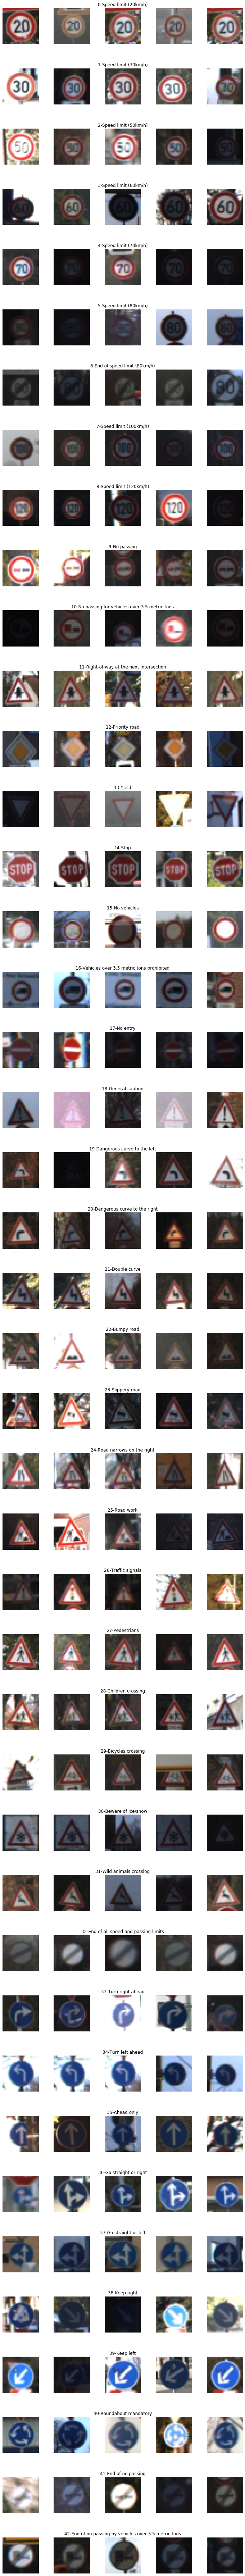

In [4]:
data = pd.read_csv("dataset/signnames.csv")
# print(data)
num_of_samples = []
cols = 5
num_classes = 43


fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (10, 100))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
#         print(y_train.shape)
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))
    

### PLT DISTRIBUTION OF THE TRAIN DATASET

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


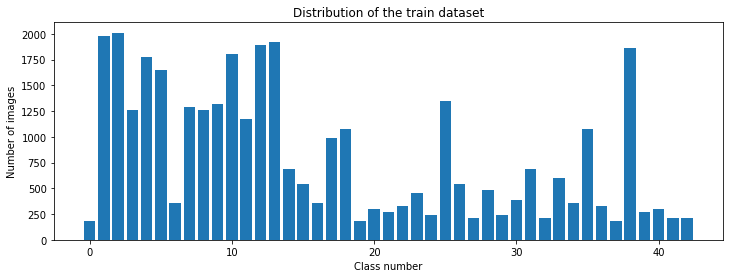

In [5]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


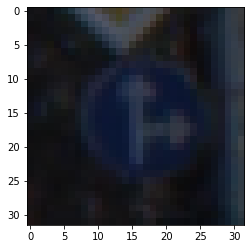

In [6]:
original_image = X_train[1000]
plt.imshow(original_image)
print(X_train[1000].shape)
print(y_train[1000])

### CONVERT COLOR MAP

(32, 32)


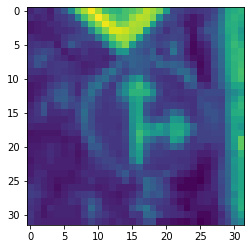

In [7]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

img = grayscale(original_image)
plt.imshow(img)
print(img.shape)

### PREPROCESS

In [8]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

### EQUILIZEHIST

(32, 32)


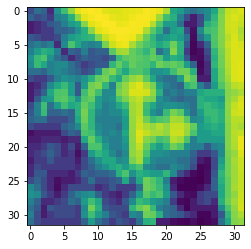

In [9]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
print(img.shape)

In [10]:
X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

In [11]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1, 'Zoomed Image')

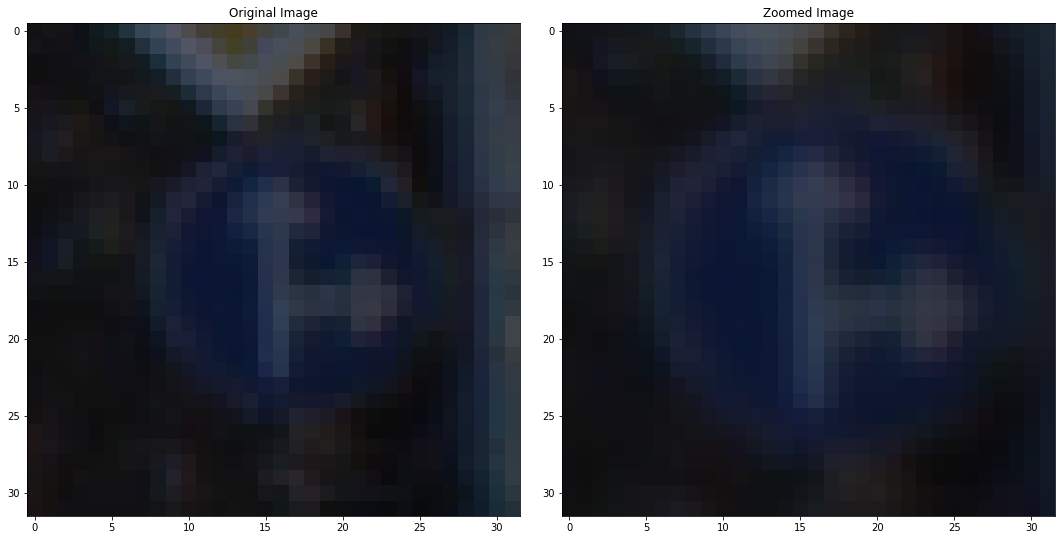

In [12]:
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [13]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1, 'Panned Image')

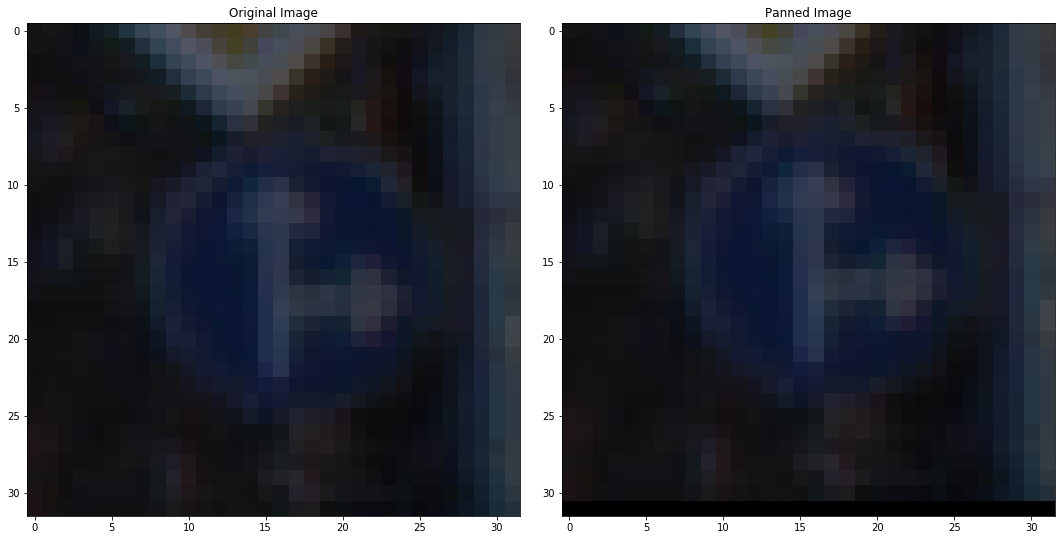

In [14]:
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [15]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Brightness altered image ')

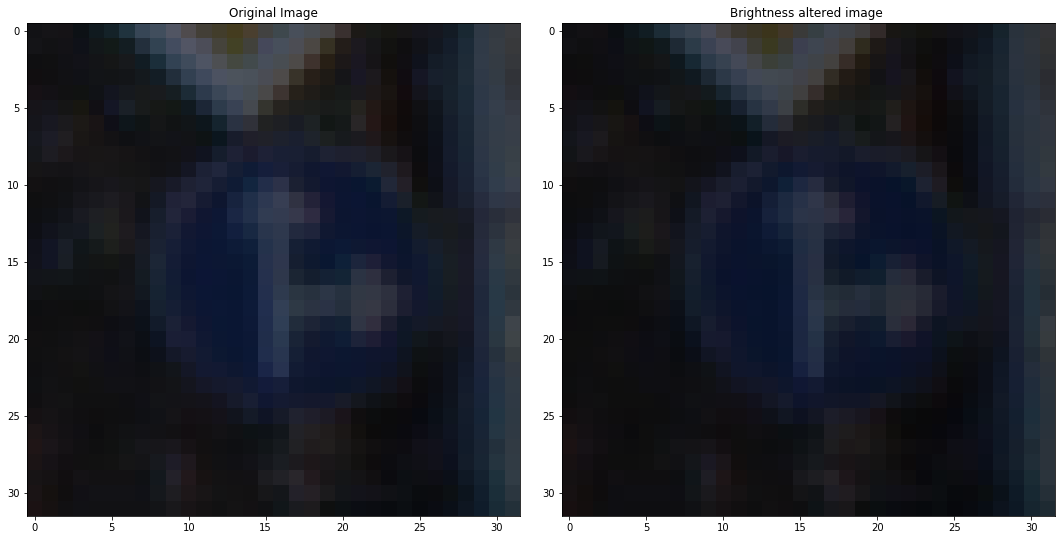

In [16]:
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [17]:
def random_augment(image):
    
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    
    return image

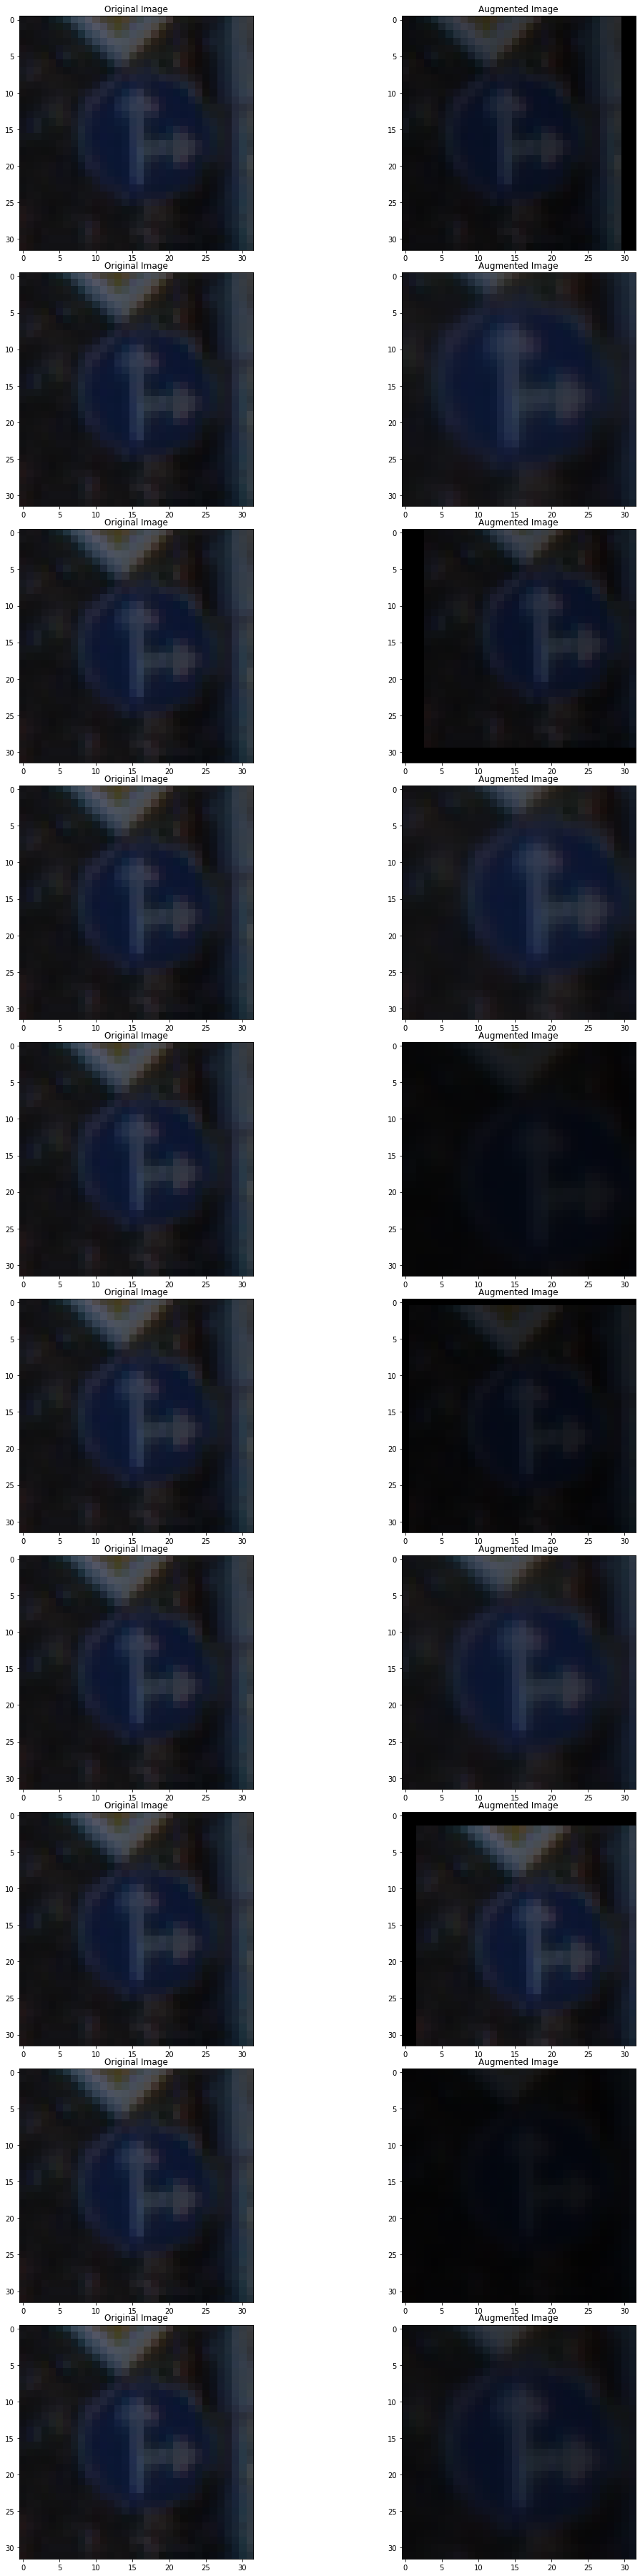

In [18]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    augmented_image = random_augment(original_image)
     
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [19]:
# def batch_generator(image_paths, steering_ang, batch_size, istraining):

#     while True:
#         batch_img = []

#         for i in range(batch_size):
            
#             if istraining:
#                 im = random_augment(original_image)
#             else:
#                 im = original_image

#             im = preprocessing(im)
#             batch_img.append(im)
#             yield (np.asarray(batch_img), steering_ang)  

In [20]:
# x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
# x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
# fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
 
# axs[0].imshow(x_train_gen[0])
# axs[0].set_title('Training Image')
 
# axs[1].imshow(x_valid_gen[0])
# axs[1].set_title('Validation Image')

In [21]:
def generate(images, count):
    generated = []
#     print(images)
    while True:
        for image in images:
            if len(generated) == count:
                return generated
            image = random_augment(image)
            generated.append(np.expand_dims(image, axis=2))

In [22]:
print(max(num_of_samples))

2010


# DATA AUGMENTATION

In [23]:
unique, counts = np.unique(y_train, return_counts=True)

target = max(num_of_samples)
x_augmented = []
y_augmented = []

for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'):
    diff = target - count
#     print(diff, target, count)
    x_augmented += generate(X_train[np.where(y_train == cls)[0]], diff)
    y_augmented += [cls for _ in range(diff)]


    
print(X_train.shape)
print(np.array(x_augmented).shape)
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
x_train = np.concatenate([X_train, np.array(x_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])
n_train = y_train.size
print('Final number of training samples', n_train)

Augmenting training dataset: 100%|██████████| 43/43 [00:16<00:00,  1.81it/s]


(34799, 32, 32)
(51631, 32, 32, 1)
Final number of training samples 86430


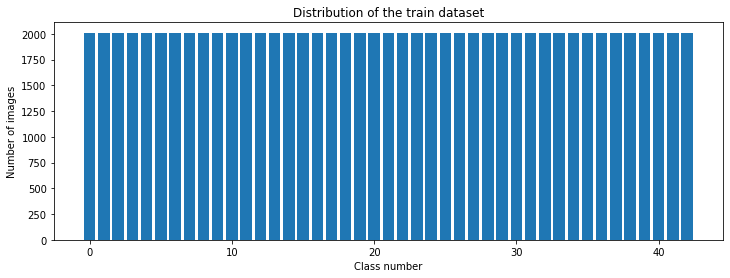

In [24]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), target)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### SHUFFLING

In [25]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(x_train, y_train)

### DEFINE A MODEL ARC

In [26]:
EPOCHS = 50
BATCH_SIZE = 100

In [27]:
def conv2d(x, kernel, Input, Output, mean = 0, sigma = 0.1):
    """ 
    return the convolution 
    """
    
    shape = (kernel, kernel, Input, Output)
    print(shape)
    conv_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mean, stddev = sigma))
#     print('conv_W : ',conv_W)
    conv_b = tf.Variable(tf.zeros(Output))
#     print('conv_b : ',conv_b)
    conv = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    conv = tf.nn.bias_add(conv, conv_b)
    return conv

conv2d(tf.placeholder(tf.float32, (None, 32, 32, 1)), 3, 1, 12)

(3, 3, 1, 12)


<tf.Tensor 'BiasAdd:0' shape=(?, 30, 30, 12) dtype=float32>

In [28]:
def maxPool(conv, pool_size):
    """ 
    return the pool 
    """
    
    pool = tf.nn.max_pool(conv, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='VALID')
    return pool

In [29]:
def fully(fc_i, Input, Output, mu = 0, sigma = 0.1):
    """ 
    return the fully convolutional networks 
    """
    
    shape = (Input, Output)
    fc_W = tf.Variable(tf.truncated_normal(shape=shape, mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(Output))
    fc   = tf.matmul(fc_i, fc_W) + fc_b
    return fc

In [30]:
from tensorflow.contrib.layers import flatten

def trafficNet(x):
    print("x : ",x)
    
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(x, 3, 1, 12)
    conv1 = tf.nn.relu(conv1)
    print("conv1 : ",conv1)
    
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(conv1, 3, 12, 24)
    conv1 = tf.nn.relu(conv1)
    pool1 = maxPool(conv1, 2)

    # 5x5 convolution with ReLU activation
    conv2 = conv2d(pool1, 5, 24, 36)
    conv2 = tf.nn.relu(conv2)
    print("conv2 : ",conv2)
    
    # 5x5 convolution with ReLU activation
    conv2 = conv2d(conv2, 5, 36, 48)
    conv2 = tf.nn.relu(conv2)
    pool2 = maxPool(conv2, 2)
    
    # Flatten
    fc0   = flatten(conv2)
    
    # Dropout
    fc0 = tf.nn.dropout(fc0, 1)
    
    # First Fully
    fc1 = fully(fc0, 1728, 512)
    fc1 = tf.nn.relu(fc1)

    # Second Fully
    fc2 = fully(fc1, 512, 256)
    fc2 = tf.nn.relu(fc2)

    # Output layer
    logits = fully(fc2, 256, num_classes)
    
    return logits, conv1, conv2

In [31]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_classes)

In [32]:
logits, conv1, conv2 = trafficNet(x)

W0307 17:19:26.278162 140256429578048 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0307 17:19:26.396367 140256429578048 deprecation.py:506] From <ipython-input-30-663d520c5f2f>:30: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


x :  Tensor("Placeholder_1:0", shape=(?, 32, 32, 1), dtype=float32)
(3, 3, 1, 12)
conv1 :  Tensor("Relu:0", shape=(?, 30, 30, 12), dtype=float32)
(3, 3, 12, 24)
(5, 5, 24, 36)
conv2 :  Tensor("Relu_2:0", shape=(?, 10, 10, 36), dtype=float32)
(5, 5, 36, 48)


In [33]:
l_rate = 0.001
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

In [34]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### TRAINING

In [ ]:
stopped_at = 5
best_epoch = 0
best_val_acc = 0
history = []

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

with sess as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print()
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        history.append([train_accuracy, validation_accuracy])
#         saver.save(sess, './model/model')
#         print("Model saved")
        if validation_accuracy > best_val_acc:
            best_epoch, best_val_acc = i, validation_accuracy
            saver.save(sess, './model/model')
            print("\x1b[32m MODEL SAVE \x1b[0m")
        else:
            if i - best_epoch == stopped_at:
                print()
                print('Stopping after {} epochs without improvement'.format(stopped_at))
                break

Training...

EPOCH 1 ...
Training Accuracy = 0.944
Validation Accuracy = 0.940

 MODEL SAVE 

EPOCH 2 ...
Training Accuracy = 0.978
Validation Accuracy = 0.964

 MODEL SAVE 

EPOCH 3 ...
Training Accuracy = 0.989
Validation Accuracy = 0.967

 MODEL SAVE 

EPOCH 4 ...
Training Accuracy = 0.989
Validation Accuracy = 0.963


EPOCH 5 ...
Training Accuracy = 0.982
Validation Accuracy = 0.953


EPOCH 6 ...
Training Accuracy = 0.997
Validation Accuracy = 0.978

 MODEL SAVE 

EPOCH 7 ...
Training Accuracy = 0.988
Validation Accuracy = 0.964



In [ ]:
def resultsAccuracy() :
    """
    Restore the session 'tf.train.saver().restore' `https://www.tensorflow.org/guide/saved_model`
    Get the last checkpoint in my model
    
    """
    
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('./model'))
        test_accuracy = evaluate(X_test, y_test)
        train_accuracy = evaluate(X_train, y_train)
        valid_accuracy = evaluate(X_valid, y_valid)
        print("Test Accuracy = {:.3f} %".format(test_accuracy * 100))
        print("Train Accuracy = {:.3f} %".format(train_accuracy * 100))
        print("Valid Accuracy = {:.3f} %".format(valid_accuracy * 100))
        
resultsAccuracy()

In [ ]:
#def plot_history(history):
#     plt.plot(history)
#     plt.legend(['Training', 'Validation'])
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.show()

# plot_history(history)

### PHASE TEST THE  MODEL WITH NEW PICTURES

In [ ]:
def localPic():
    """
    Pictures in local
    """
    
    
#     pic = './examples/pic1.jpg'       #30km/h
#     pic = './examples/pic2.jpg'       #no entry
    pic = './examples/pic3.jpg'       #yiel
#     pic = './examples/pic4.jpg'       #bicycles crossing
#     pic = './examples/pic5.jpg'       #turn left ahead
#     pic = './examples/pic6.jpg'       #turn right
#     pic = './examples/pic7.jpg'       #80km/h
#     pic = './examples/pic8.jpg'       #no passing 3.5t
#     pic = './examples/pic9.jpg'       #70km/h
#     pic = './examples/pic10.jpg'      #no passing
#     image = mpimg.imread(pic)
    return pic

In [ ]:
import requests
from PIL import Image

def netPic():
    """
    Get picture from the fabulous internet and return it
    """
    
#     url = "http://media.gettyimages.com/photos/traffic-sign-bicycling-prohibited-germany-picture-id486920319?s=170667a&w=1007"
#     url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
#     url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
#     url = "https://c8.alamy.com/compfr/t17h0w/panneau-routier-fin-interdiction-de-depassement-pour-les-vehicules-a-moteur-de-toutes-sortes-allemagne-t17h0w.jpg"
#     url = "https://www.direct-signaletique.com/I-Autre-24456_459x459-.net.jpg"
    url = "https://previews.123rf.com/images/sergey02/sergey021301/sergey02130100049/17158070-arr%C3%AAtez-panneau-de-signalisation-routi%C3%A8re-en-jour-de-neige-en-hiver-canada.jpg"
#     url = "https://www.francetvinfo.fr/image/75n7tjcsc-9796/1200/450/16925063.jpg"
#     url = "YOUR URL PICTURE"

    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    return img

In [ ]:
def testing():
#     return localPic(), True           #<------# LOCAL PIC
    return netPic(), False          #<------# INTERNET PIC

### GET TOP FIVE SOFTMAX PROBABILITIES AND PREDICTION 

In [ ]:
def topFiveSoftmax(output, maxes):
    """
    print out the top five softmax probabilities for the predictions
    """
    
    with tf.Session() as sess:
        tops = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(output)),k = 5)) 
        indices = []
        values = []
        res_append = []
            
        for i in tops.indices[0].tolist():
            num = tops.indices[0].tolist().index(i)+1
            for j, cnt in zip(maxes,range(len(maxes))):
                classid = np.where(output[cnt]>=maxes[cnt])[0][0]
                for k, row in data.iterrows():
                    if i == row["ClassId"]:
                        indices.append(['Position {} :'.format(num), row["ClassId"] ,row["SignName"]])
        for i_b in tops.values[0].tolist():
            for j, cnt in zip(maxes,range(len(maxes))):
                classid = np.where(output[cnt]>=maxes[cnt])[0][0]
                values.append([i_b*100])
        res_append.append([indices, values])
        
        for res in res_append:
            for i in range(len(values)):
                val = int(res[1][i][0])
                if val >= 95:
                    c = '32'
                elif val in range(80, 95):
                    c = '33'
                else:
                    c = '31'
                print(res[0][i][0], res[0][i][1], res[0][i][2], ':\x1b['+c+'m {:.3f}% \x1b[0m'.format(res[1][i][0]))

In [ ]:
def preprocess(img):
    """
    Preprocess image
    """
    
    print()
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    return img, False

### PREDICTION

In [ ]:
def prediction(img):
    """
    Return the Prediction
    """

    img, _ = preprocess(img)
    new_saver = tf.train.import_meta_graph('./model/model.meta')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        new_saver.restore(sess, tf.train.latest_checkpoint('./model'))
        test_accuracy = evaluate(X_test, y_test)
        img = img.reshape(1, 32, 32, 1)
        output = sess.run(logits, feed_dict={x: img})
    maxes = np.amax(output,axis=1)
    cl = np.zeros((len(maxes)))
    cnt = 0
    topFiveSoftmax(output, maxes)
    for m,cnt in zip(maxes,range(len(maxes))):
        classid = np.where(output[cnt]>=maxes[cnt])[0][0]
        for i, row in data.iterrows():
            if classid == row["ClassId"]:
                return "FINAL PREDICT : ",row["ClassId"] ,row["SignName"]

In [ ]:
def displayResult(about = True):
    """
    Display all results
    """
    
    if about == True:
        rows = 2
        cols = 5
        fig, axs = plt.subplots(rows,cols)
        fig.set_size_inches(25,10)
        paths = os.getcwd()+'/examples'
        files = os.listdir(paths)
        for num, fname in enumerate(files):
            image = mpimg.imread('./examples/'+fname)
            axs[int(num/cols)][num%cols].imshow(image)
            axs[int(num/cols)][num%cols].set_title(prediction(image), fontsize=12)
    else :
        image, valBool = testing()
        if valBool == True:
            return mpimg.imread(localPic())
        else:
            return image
    
image, valBool = testing()
if valBool == True:
        displayResult()
else :
    prediction(image)
    plt.imshow(image)

### VISUALIZATION NETWORK

In [ ]:
### Visualize network's feature maps here.

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    
    image_input = image_input.reshape(1, 32, 32, 1)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    print(featuremaps)#---#
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="jet")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="jet")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="jet")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="jet")
            
            
            

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    img, _ = preprocess(displayResult(False))
    outputFeatureMap(img, conv1, plt_num=1)
    outputFeatureMap(img, conv2, plt_num=2)

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()